- модель с 1 GRU слоем;
- модель с 1 LSTM слоем
- модель с 1 GRU и 1 LSTM слоем
- модель с 1 BIGRU и 2 LSTM слоями
- модель с 5 GRU слоями и 3 LSTM слоями
- модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались
- модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM




In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Классификация текста с помощью RNN

In [3]:
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
data = pd.read_csv('/content/drive/MyDrive/ВШЭ/Магистратура/NLP/lenta_40k.csv')

In [7]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [8]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

Предобработка нам тут особо не важна.

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В tf есть много встроенны метрик, но нет f1 меры. Можно воспользоваться вот такой функцией, взятой со stackoverflow

In [10]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Как и раньше, создаем словарь, фильтруем, чтобы он был адекватного размера и переводим токены в индексы

In [11]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [12]:
len(vocab)

354611

In [13]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [14]:
len(filtered_vocab)

24091

In [15]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [16]:
id2word = {i:word for word, i in word2id.items()}

In [17]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [18]:
MEAN_LEN = np.median([len(x) for x in X])

In [19]:
MAX_LEN = int(MEAN_LEN + 30)

In [20]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [21]:
X.shape

(44356, 200)

In [22]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [23]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

### модель с 1 GRU слоем

In [25]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 30)           722790    
                                                                 
 gru (GRU)                   (None, 128)               61440     
                                                                 
 dense (Dense)               (None, 19)                2451      
                                                                 
Total params: 786,681
Trainable params: 786,681
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 17s 217ms/step - loss: 2.5939 - f1: 0.0047 - rec@prec: 0.0000e+00 - val_loss: 2.3401 - val_f1: 0.0000e+00 - val_rec@prec: 0.0023
Epoch 2/20
43/43 [==============================] - 15s 345ms/step - loss: 2.2821 - f1: 0.0000e+00 - rec@prec: 1.1866e-04 - val_loss: 2.2251 - val_f1: 0.0000e+00 - val_rec@prec: 0.0036
Epoch 3/20
43/43 [==============================] - 12s 283ms/step - loss: 2.1031 - f1: 0.0046 - rec@prec: 0.0027 - val_loss: 2.0444 - val_f1: 0.0097 - val_rec@prec: 0.0027
Epoch 4/20
43/43 [==============================] - 12s 281ms/step - loss: 1.9144 - f1: 0.0670 - rec@prec: 0.0153 - val_loss: 1.8983 - val_f1: 0.1182 - val_rec@prec: 0.0275
Epoch 5/20
43/43 [==============================] - 10s 242ms/step - loss: 1.7024 - f1: 0.2118 - rec@prec: 0.0924 - val_loss: 1.8420 - val_f1: 0.1948 - val_rec@prec: 0.0528
Epoch 6/20
43/43 [==============================] - 8s 168ms/step - loss: 1.5500 - f1: 0.3458 - rec@prec: 0.1995 - 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


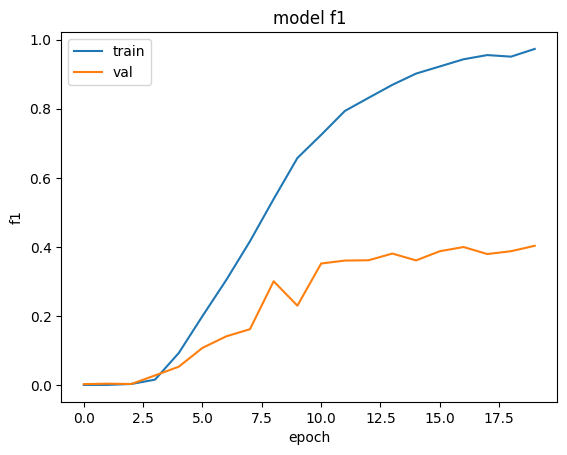

In [28]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

не очень хорошее качество

### модель с 1 LSTM слоем

In [29]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1,
                       tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [30]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 [==============================] - 12s 221ms/step - loss: 2.4769 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3181 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/20
43/43 [==============================] - 6s 149ms/step - loss: 2.3127 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.2985 - val_f1: 0.0000e+00 - val_rec@prec: 0.0018
Epoch 3/20
43/43 [==============================] - 7s 160ms/step - loss: 2.2343 - f1: 0.0000e+00 - rec@prec: 3.5597e-04 - val_loss: 2.0514 - val_f1: 0.0013 - val_rec@prec: 0.0311
Epoch 4/20
43/43 [==============================] - 6s 136ms/step - loss: 1.8735 - f1: 0.1039 - rec@prec: 0.0256 - val_loss: 1.6473 - val_f1: 0.2917 - val_rec@prec: 0.1172
Epoch 5/20
43/43 [==============================] - 7s 163ms/step - loss: 1.5432 - f1: 0.3779 - rec@prec: 0.1051 - val_loss: 1.5232 - val_f1: 0.3558 - val_rec@prec: 0.1560
Epoch 6/20
43/43 [==============================] - 4s 98ms/step - loss: 1.3314 - f1: 0.5262 - rec@prec

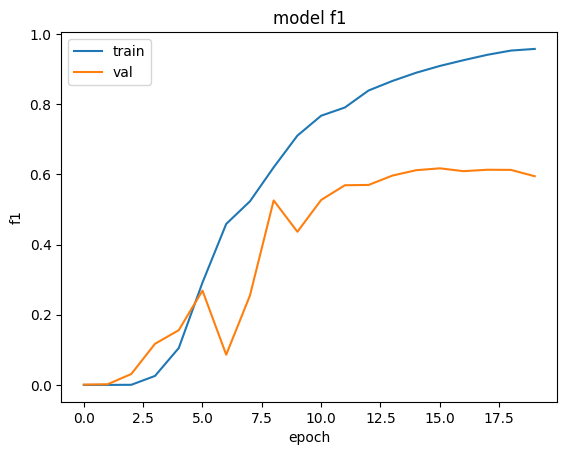

In [31]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

прямо получше

### модель с 1 GRU и 1 LSTM слоем

In [32]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_1)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [33]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 47s 204ms/step - loss: 2.1947 - f1: 0.0560 - rec@prec: 0.0211 - val_loss: 1.6182 - val_f1: 0.2644 - val_rec@prec: 0.1434
Epoch 2/15
211/211 [==============================] - 31s 146ms/step - loss: 1.3966 - f1: 0.5214 - rec@prec: 0.3206 - val_loss: 1.3311 - val_f1: 0.5718 - val_rec@prec: 0.3751
Epoch 3/15
211/211 [==============================] - 20s 93ms/step - loss: 1.1426 - f1: 0.6357 - rec@prec: 0.5121 - val_loss: 1.2043 - val_f1: 0.6220 - val_rec@prec: 0.4378
Epoch 4/15
211/211 [==============================] - 18s 85ms/step - loss: 0.9852 - f1: 0.6953 - rec@prec: 0.6230 - val_loss: 1.1846 - val_f1: 0.6559 - val_rec@prec: 0.5086
Epoch 5/15
211/211 [==============================] - 14s 66ms/step - loss: 0.9176 - f1: 0.7241 - rec@prec: 0.6726 - val_loss: 1.2673 - val_f1: 0.6289 - val_rec@prec: 0.4292
Epoch 6/15
211/211 [==============================] - 12s 58ms/step - loss: 2.2617 - f1: 0.0231 - rec@prec: 0.0126 - val_loss: 2

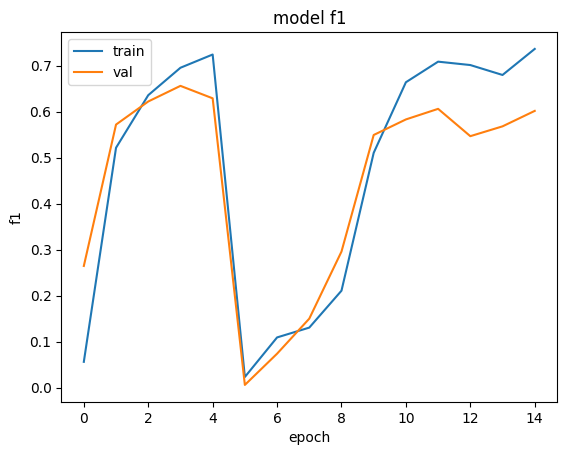

In [34]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

очень интересный скачок, качество неплохое

### модель с 1 BIGRU и 2 LSTM слоями

In [35]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [36]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 57s 236ms/step - loss: 2.0889 - f1: 0.0976 - rec@prec: 0.0463 - val_loss: 1.8816 - val_f1: 0.2038 - val_rec@prec: 0.0775
Epoch 2/15
211/211 [==============================] - 37s 174ms/step - loss: 1.6398 - f1: 0.3246 - rec@prec: 0.1547 - val_loss: 1.6793 - val_f1: 0.4831 - val_rec@prec: 0.1479
Epoch 3/15
211/211 [==============================] - 28s 130ms/step - loss: 1.2890 - f1: 0.5553 - rec@prec: 0.3135 - val_loss: 1.2811 - val_f1: 0.5514 - val_rec@prec: 0.3201
Epoch 4/15
211/211 [==============================] - 25s 120ms/step - loss: 1.0331 - f1: 0.6560 - rec@prec: 0.5224 - val_loss: 1.1348 - val_f1: 0.6312 - val_rec@prec: 0.4599
Epoch 5/15
211/211 [==============================] - 23s 110ms/step - loss: 0.8885 - f1: 0.7205 - rec@prec: 0.6582 - val_loss: 1.0526 - val_f1: 0.6840 - val_rec@prec: 0.5559
Epoch 6/15
211/211 [==============================] - 24s 115ms/step - loss: 0.7465 - f1: 0.7783 - rec@prec: 0.7661 - val_los

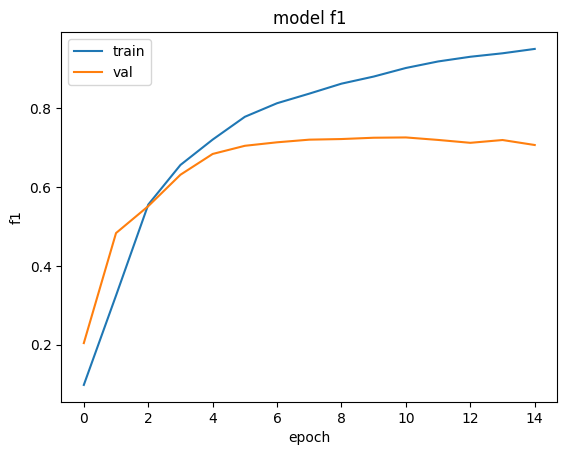

In [37]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

О, получше качество, чем у предыдущих

### модель с 5 GRU слоями и 3 LSTM слоями

In [38]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(gru_1)
gru_3 = tf.keras.layers.GRU(128, return_sequences=True)(gru_2)
gru_4 = tf.keras.layers.GRU(128, return_sequences=True)(gru_3)
gru_5 = tf.keras.layers.GRU(128, return_sequences=True)(gru_4)
lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(gru_5)
lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True)(lstm_1)
lstm_3 = tf.keras.layers.LSTM(128, return_sequences=False)(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [39]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 [==============================] - 68s 253ms/step - loss: 2.3449 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3200 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/15
211/211 [==============================] - 41s 197ms/step - loss: 2.3124 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3177 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/15
211/211 [==============================] - 36s 173ms/step - loss: 2.3026 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2993 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/15
211/211 [==============================] - 34s 162ms/step - loss: 2.2683 - f1: 0.0100 - rec@prec: 2.3732e-05 - val_loss: 2.0611 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/15
211/211 [==============================] - 33s 157ms/step - loss: 1.8479 - f1: 0.1113 - rec@prec: 0.0504 - val_loss: 1.7231 - val_f1: 0.2373 - val_rec@prec: 0.0888
Epoch 6/15
211/211 [==============================] - 32s 153ms/s

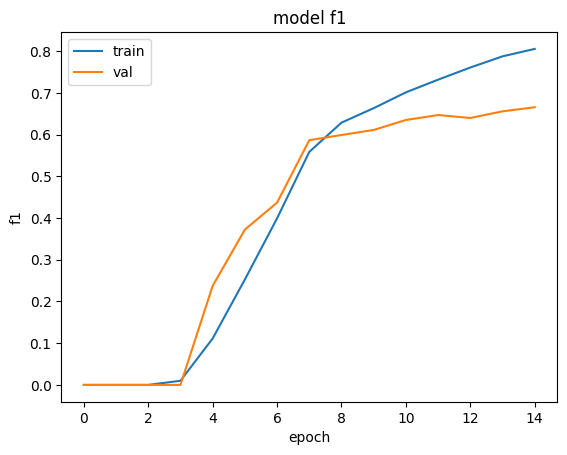

In [40]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Качество почти такое, как у предыдущей модели. А какая картинка обучения выглядит лучше? Вот на этой линии в конце идут вверх, то есть можно было ещё несколько эпох пообучать и немного качество, наверно, улучшилось бы.

### модель 1 BIGRU и 1 BILSTM слоями, причем так, чтобы модели для forward и backward прохода отличались

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=50)(inputs, )

bigru = tf.keras.layers.Bidirectional(
                                    tf.keras.layers.GRU(128, return_sequences=True),
                        backward_layer=tf.keras.layers.GRU(256, return_sequences=True,
                                                            go_backwards=True))(embeddings)
bilstm = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=False),
                        backward_layer=tf.keras.layers.LSTM(256, return_sequences=False,
                                                            go_backwards=True))(bigru)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bilstm)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=10)

Epoch 1/10


2023-02-08 14:55:39.922753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:40.329605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:40.340415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:41.228043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:55:41.243037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - ETA: 0s - loss: 2.1624 - f1: 0.0134 - rec@prec: 1.1866e-04

2023-02-08 14:56:31.820715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:56:31.962997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-08 14:56:31.984077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


211/211 [==============================] - 56s 247ms/step - loss: 2.1624 - f1: 0.0134 - rec@prec: 1.1866e-04 - val_loss: 1.9003 - val_f1: 0.0730 - val_rec@prec: 0.0654
Epoch 2/10
211/211 [==============================] - 46s 218ms/step - loss: 1.6782 - f1: 0.2219 - rec@prec: 0.1038 - val_loss: 1.7796 - val_f1: 0.2734 - val_rec@prec: 0.1506
Epoch 3/10
211/211 [==============================] - 46s 219ms/step - loss: 1.4556 - f1: 0.4397 - rec@prec: 0.2027 - val_loss: 1.5384 - val_f1: 0.4130 - val_rec@prec: 0.2408
Epoch 4/10
211/211 [==============================] - 45s 215ms/step - loss: 1.2103 - f1: 0.5949 - rec@prec: 0.4487 - val_loss: 1.5127 - val_f1: 0.5365 - val_rec@prec: 0.0857
Epoch 5/10
211/211 [==============================] - 46s 216ms/step - loss: 1.0593 - f1: 0.6695 - rec@prec: 0.5816 - val_loss: 1.3573 - val_f1: 0.5289 - val_rec@prec: 0.2719
Epoch 6/10
211/211 [==============================] - 46s 218ms/step - loss: 0.9084 - f1: 0.7219 - rec@prec: 0.6756 - val_loss: 1.24

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


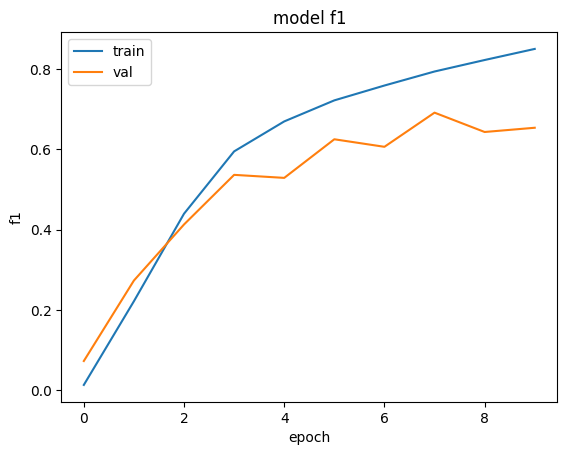

In [ ]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

У предыдущей качество лучше было

### модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [56]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=50)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)

gru_1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm_1)

bilstm = tf.keras.layers.Bidirectional(
                                       tf.keras.layers.LSTM(128, return_sequences=True),
                        backward_layer=tf.keras.layers.LSTM(64, return_sequences=True,
                                                            go_backwards=True))(gru_1)
bigru = tf.keras.layers.Bidirectional(
                                    tf.keras.layers.GRU(128, return_sequences=True),
                        backward_layer=tf.keras.layers.GRU(64, return_sequences=True,
                                                            go_backwards=True))(bilstm)


gru_2 = tf.keras.layers.GRU(128, return_sequences=True)(bigru)

lstm_2 = tf.keras.layers.LSTM(128, return_sequences=False)(gru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [57]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=10)

Epoch 1/10
211/211 [==============================] - 68s 241ms/step - loss: 2.3405 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2272 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
211/211 [==============================] - 41s 194ms/step - loss: 2.0237 - f1: 0.0246 - rec@prec: 0.0062 - val_loss: 1.8166 - val_f1: 0.1160 - val_rec@prec: 0.0622
Epoch 3/10
211/211 [==============================] - 34s 163ms/step - loss: 1.7540 - f1: 0.1340 - rec@prec: 0.0700 - val_loss: 1.8389 - val_f1: 0.2385 - val_rec@prec: 0.1172
Epoch 4/10
211/211 [==============================] - 34s 161ms/step - loss: 1.5120 - f1: 0.2980 - rec@prec: 0.1574 - val_loss: 1.4434 - val_f1: 0.3714 - val_rec@prec: 0.1894
Epoch 5/10
211/211 [==============================] - 32s 150ms/step - loss: 1.3277 - f1: 0.5048 - rec@prec: 0.2456 - val_loss: 1.3550 - val_f1: 0.5365 - val_rec@prec: 0.2412
Epoch 6/10
211/211 [==============================] - 31s 146ms/step - loss: 1.1811 - f1: 0.5954 - rec@prec: 

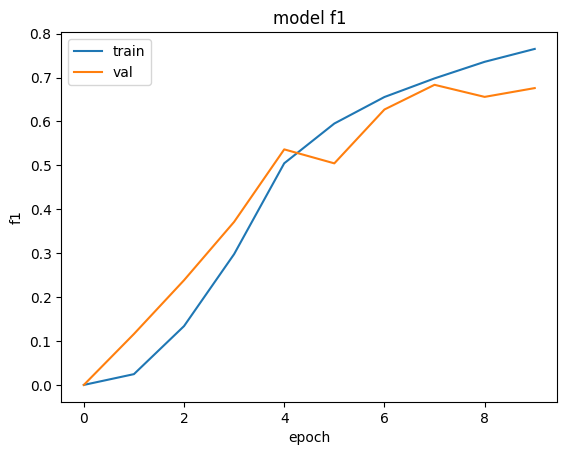

In [58]:
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Качество хорошее. Если дальше обучать, качество будет падать, проверила

# Sequence labelling

Данные возьмем из бибиотеки datasets (часть huggingface)

In [44]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 22.1 MB/s eta 0:00:00


In [45]:
from datasets import load_dataset

В этой библиотеке несколько датасетов для именованных сущностей. Мы возьмем датасет, собранный по википедии. Он мультиязычный, но для семинара мы возьмем только русскую часть.

In [46]:
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Датасет уже заранее разбит на трейн, валидацию и тест.

In [47]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

Пример данных

In [48]:
dataset['train']['tokens'][0], dataset['train']['ner_tags'][0]

(['Илизаров', ',', 'Гавриил', 'Абрамович'], [1, 2, 2, 2])

In [49]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [50]:
# тут словарь не очень большой и тут нужно предсказывать тэги для всех слов
# поэтому не будем фильтровать словарь
len(vocab)

36015

In [51]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [52]:
id2word = {i:word for word, i in word2id.items()}

In [53]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [59]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [60]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

Теги уже переведены в индексы, но обратный маппинг мы тоже сделаем, чтобы дальше удобнее было проверять работу модели.
Длина последовательностей тегов должна совпадать с длиной последовательностей токенов, поэтому тут тоже нужно сделать паддинг, но в этом случае мы не можем паддить нулями, т.к. ноль у нас уже забронирован тэгом O. Добавим дополнительный тэг пад и будем использовать его индекс при паддинге (value=7)

In [61]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [62]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

### модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев

In [64]:
import gensim

In [66]:
w2v = gensim.models.Word2Vec(dataset['train']['tokens'],
                             vector_size=300,
                             min_count=20,
                             max_vocab_size=10000,
                             window=5,
                             epochs=7,
                             sample=1e-5,
                             sg=1)

In [69]:
weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue
    try:
        weights[i] = w2v.wv[word]

    except KeyError:
        continue
        weights[i] = w2v.wv['cghvjb']

In [71]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=True,
                                       weights=[weights])(inputs, )

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(lstm_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_3)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=200,
          epochs=8)

Epoch 1/8
100/100 [==============================] - 40s 265ms/step - loss: 0.3025 - accuracy: 0.9204 - val_loss: 0.1542 - val_accuracy: 0.9523
Epoch 2/8
100/100 [==============================] - 15s 153ms/step - loss: 0.1298 - accuracy: 0.9585 - val_loss: 0.1117 - val_accuracy: 0.9642
Epoch 3/8
100/100 [==============================] - 12s 120ms/step - loss: 0.0858 - accuracy: 0.9726 - val_loss: 0.0865 - val_accuracy: 0.9736
Epoch 4/8
100/100 [==============================] - 9s 93ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0606 - val_accuracy: 0.9805
Epoch 5/8
100/100 [==============================] - 10s 96ms/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0630 - val_accuracy: 0.9796
Epoch 6/8
100/100 [==============================] - 9s 90ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.0659 - val_accuracy: 0.9808
Epoch 7/8
100/100 [==============================] - 9s 85ms/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 0.0700 - val_accuracy: 0.9807

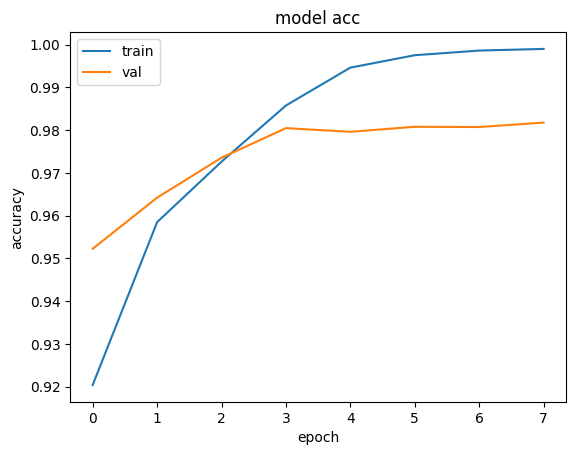

In [73]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Оценивать предсказания последовательностей нужно отдельно. Лучше конечно еще оценивать правильность всей последовательности, но пока сделаем только поэлементную оценку.

In [74]:
from sklearn.metrics import classification_report

In [75]:
pred = model.predict(X_test).argmax(2)

313/313 [==============================] - 6s 11ms/step


In [77]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.92      0.94      0.93     40480
       B-PER       0.93      0.72      0.81      3542
       I-PER       0.96      0.74      0.83      7544
       B-ORG       0.56      0.76      0.65      4074
       I-ORG       0.78      0.79      0.78      8008
       B-LOC       0.71      0.77      0.74      4560
       I-LOC       0.88      0.71      0.79      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.84      0.80      0.82    540000
weighted avg       0.98      0.98      0.98    540000



In [78]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    return list(zip(tokens, labels))

In [80]:
label_seq('В туристическом стойбище "Мэнэдек" на Камчатке Надежда Егоровна Инданова повесила плакат, который Таня забрала у организатора фестиваля "Сокровища Севера"', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 28ms/step


[('В', 'O'),
 ('туристическом', 'O'),
 ('стойбище', 'O'),
 ('"', 'O'),
 ('Мэнэдек', 'O'),
 ('"', 'O'),
 ('на', 'O'),
 ('Камчатке', 'O'),
 ('Надежда', 'B-PER'),
 ('Егоровна', 'O'),
 ('Инданова', 'O'),
 ('повесила', 'O'),
 ('плакат', 'O'),
 (',', 'O'),
 ('который', 'O'),
 ('Таня', 'B-ORG'),
 ('забрала', 'O'),
 ('у', 'O'),
 ('организатора', 'O'),
 ('фестиваля', 'O'),
 ('"', 'O'),
 ('Сокровища', 'O'),
 ('Севера', 'O'),
 ('"', 'O')]

In [81]:
label_seq('Мне подарили футболку Политеха на конференции в Питере', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 34ms/step


[('Мне', 'O'),
 ('подарили', 'O'),
 ('футболку', 'O'),
 ('Политеха', 'O'),
 ('на', 'O'),
 ('конференции', 'B-ORG'),
 ('в', 'O'),
 ('Питере', 'B-ORG')]

In [82]:
label_seq('Сериал про Майку был снят в Чехосовакии', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 44ms/step


[('Сериал', 'O'),
 ('про', 'O'),
 ('Майку', 'B-LOC'),
 ('был', 'O'),
 ('снят', 'O'),
 ('в', 'O'),
 ('Чехосовакии', 'B-LOC')]

### модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев

In [84]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300,
                                       trainable=True,
                                       weights=[weights])(inputs, )


bigru_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru_2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True))(bigru_1)
bigru_3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru_2)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru_3)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [85]:
model2.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=200,
          epochs=8)

Epoch 1/8
100/100 [==============================] - 36s 252ms/step - loss: 0.2910 - accuracy: 0.9227 - val_loss: 0.1242 - val_accuracy: 0.9584
Epoch 2/8
100/100 [==============================] - 16s 165ms/step - loss: 0.0760 - accuracy: 0.9753 - val_loss: 0.0558 - val_accuracy: 0.9821
Epoch 3/8
100/100 [==============================] - 11s 109ms/step - loss: 0.0234 - accuracy: 0.9928 - val_loss: 0.0523 - val_accuracy: 0.9842
Epoch 4/8
100/100 [==============================] - 11s 114ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.0592 - val_accuracy: 0.9834
Epoch 5/8
100/100 [==============================] - 10s 104ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.0637 - val_accuracy: 0.9832
Epoch 6/8
100/100 [==============================] - 9s 93ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0723 - val_accuracy: 0.9824
Epoch 7/8
100/100 [==============================] - 9s 92ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0716 - val_accuracy: 0.9

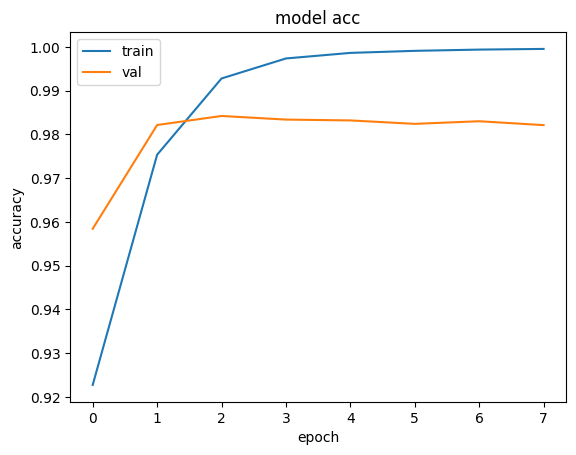

In [86]:
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
pred = model2.predict(X_test).argmax(2)

313/313 [==============================] - 5s 9ms/step


In [88]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.94      0.92      0.93     40480
       B-PER       0.84      0.87      0.85      3542
       I-PER       0.91      0.81      0.86      7544
       B-ORG       0.51      0.80      0.63      4074
       I-ORG       0.80      0.80      0.80      8008
       B-LOC       0.72      0.77      0.75      4560
       I-LOC       0.91      0.68      0.78      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.83      0.83      0.82    540000
weighted avg       0.98      0.98      0.98    540000



In [91]:
label_seq('В туристическом стойбище "Мэнэдек" на Камчатке Надежда Егоровна Инданова повесила плакат, который Таня забрала у организатора фестиваля "Сокровища Севера"', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 35ms/step


[('В', 'O'),
 ('туристическом', 'B-ORG'),
 ('стойбище', 'I-ORG'),
 ('"', 'O'),
 ('Мэнэдек', 'O'),
 ('"', 'O'),
 ('на', 'O'),
 ('Камчатке', 'B-ORG'),
 ('Надежда', 'I-PER'),
 ('Егоровна', 'I-PER'),
 ('Инданова', 'O'),
 ('повесила', 'I-PER'),
 ('плакат', 'I-PER'),
 (',', 'O'),
 ('который', 'O'),
 ('Таня', 'B-PER'),
 ('забрала', 'O'),
 ('у', 'O'),
 ('организатора', 'O'),
 ('фестиваля', 'O'),
 ('"', 'B-PER'),
 ('Сокровища', 'I-PER'),
 ('Севера', 'O'),
 ('"', 'B-ORG')]

In [92]:
label_seq('Мне подарили футболку Политеха на конференции в Питере', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 25ms/step


[('Мне', 'O'),
 ('подарили', 'O'),
 ('футболку', 'O'),
 ('Политеха', 'O'),
 ('на', 'O'),
 ('конференции', 'B-ORG'),
 ('в', 'O'),
 ('Питере', 'B-ORG')]

In [93]:
label_seq('Сериал про Майку был снят в Чехосовакии', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 26ms/step


[('Сериал', 'O'),
 ('про', 'O'),
 ('Майку', 'B-LOC'),
 ('был', 'O'),
 ('снят', 'O'),
 ('в', 'O'),
 ('Чехосовакии', 'B-LOC')]

По accuracy модели получились почти одинаковые. Но мне больше нравится как с примером №1 справилась модель из bigru слоёв (с остальными примерами одинаково получилось). Но я не понимаю, почему так плохо у обеих моделей с первым примером. Там же кавычки стоят. То есть именнованная сущность прям выделена...